###1. 라이브러리 불러오기

In [1]:
import os
import shutil
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms

# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###2. 데이터셋 정의 - 비오염

In [ ]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
add_set = CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1975338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7865399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5245317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605

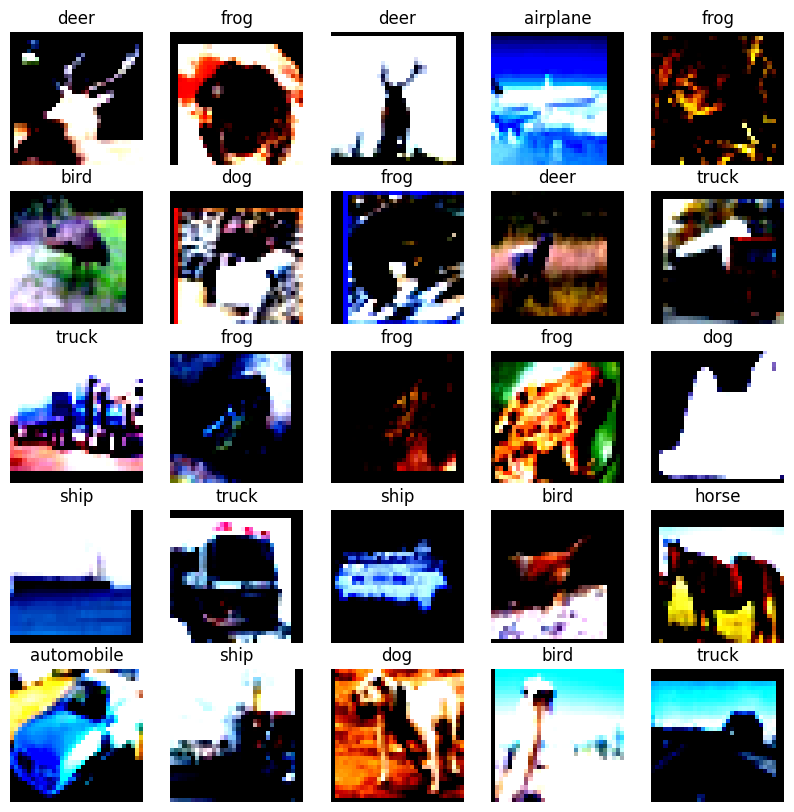

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

classes = train_set.classes

batch = next(iter(train_loader))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

###3. 신경망 코딩 - ResNet50

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

###4. 신경망 학습과 테스트 진행

In [ ]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [ ]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

In [ ]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 0.812
Accuracy: 74.56%
[Epoch 2] loss: 0.737
Accuracy: 76.94%
[Epoch 3] loss: 0.632
Accuracy: 79.39%
[Epoch 4] loss: 0.572
Accuracy: 79.26%
[Epoch 5] loss: 0.521
Accuracy: 81.41%


### CIFAR-10 / 100 데이터 클래스 생성

In [ ]:
cifar10_label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
cifar100_label_dict = {
1: 'apple', # id 0
2: 'aquarium_fish',
3:'baby',
4: 'bear',
5: 'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
}

# CIFAR-100 fine labels 
cifar100_label_map =  {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    'fish': ['aquarium fish', 'flatfish', 'ray', 'shark', 'trout'],
    'flowers': ['orchids', 'poppies', 'roses', 'sunflowers', 'tulips'],
    'food containers': ['bottles', 'bowls', 'cans', 'cups', 'plates'],
    'fruit and vegetables': ['apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers'],
    'household electrical devices': ['clock', 'computer', 'keyboard', 'lamp', 'telephone', 'television'],
    'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
    'people': ['baby', 'boy', 'girl', 'man', 'woman'],
    'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    'trees': ['maple', 'oak', 'palm', 'pine', 'willow'],
    'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup truck', 'train'],
    'vehicles 2': ['lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

# 결과를 담을 딕셔너리
combined_label_dict  = {}

# CIFAR-10 레이블을 combined_dict에 추가
for idx, label in cifar10_label_dict.items():
    combined_label_dict[idx] = label  # CIFAR-10은 0부터 9까지 사용

# CIFAR-100 레이블을 combined_dict에 추가 (10부터 109까지 사용)
cifar100_label_idx = 10  # CIFAR-100의 첫 번째 레이블 번호는 10부터 시작

for category, items in cifar100_label_dict.set():
    for item in items:
        combined_label_dict[cifar100_label_idx] = item  # 레이블 번호는 10부터 시작
        cifar100_label_idx += 1  # 레이블 번호 증가

# 출력하여 확인
for key, value in combined_label_dict.items():
    print(f"{key}: {value}")

# 데이터셋을 위한 커스텀 Dataset 클래스 생성
class CombinedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)

AttributeError: 'set' object has no attribute 'set'

###데이터의 오염을 통한 학습 효율 변화

In [ ]:
def ood_label2(dataset, pertubationset, attack_ratio=0.1):
    """
    CIFAR-10 데이터셋에 CIFAR-100에서 특정 클래스를 추가하는 함수.

    Parameters:
    - cifar10_data (CIFAR10): 기존 CIFAR-10 데이터셋
    - cifar100_data (CIFAR100): CIFAR-100 데이터셋

    Returns:
    - combined_dataset: CIFAR-10에 CIFAR-100에서 원하는 데이터를 추가한 데이터셋
    """
    # CIFAR-100에서 원하는 클래스를 필터링
    target_class_indices = [i for i, label in enumerate(pertubationset.targets)]

    # 데이터를 무작위로 섞기 위해 인덱스를 무작위로 섞음
    indices = np.random.permutation(len(pertubationset))

    # 섞인 인덱스를 이용해 데이터를 섞음
    shuffled_data = [pertubationset[i] for i in indices]

    # 원하는 숫자의 데이터를 선택 (기본적으로 10% 샘플)
    num_attack_samples = int(attack_ratio * len(dataset))
    selected_data = [shuffled_data[i] for i in target_class_indices[:num_attack_samples]]

    # CIFAR-10과 CIFAR-100 데이터 합치기
    combined_data = dataset + selected_data

    return combined_data

In [ ]:
def load_and_combine_datasets(dataset, attack_ratio=0.1):
    # Transform 정의 (이미지 데이터를 Tensor로 변환)
    transform = transforms.Compose([transforms.ToTensor()])

    # CIFAR-10 데이터셋의 이미지와 레이블
    cifar10_images = torch.tensor(dataset.data).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
    cifar10_labels = torch.tensor(dataset.targets)  # CIFAR-10 레이블

    # CIFAR-100 데이터셋의 이미지와 레이블
    cifar100_images = torch.tensor(cifar100.data).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
    cifar100_labels = torch.tensor(cifar100.targets)  # CIFAR-100 레이블

    # CIFAR-100의 레이블을 10부터 시작하도록 수정 (CIFAR-10과 겹치지 않게)
    cifar100_labels += 10  # CIFAR-10 레이블은 0~9, CIFAR-100 레이블은 10~109

    num_attack_samples = int(attack_ratio * len(dataset))

    # CIFAR-100에서 총 num_cifar100_samples만큼 샘플 선택
    num_cifar100_classes = len(torch.unique(cifar100_labels))  # CIFAR-100에서 클래스의 수는 100개
    samples_per_class = num_attack_samples // num_cifar100_classes  # 각 클래스당 선택할 샘플의 수

    selected_images = []
    selected_labels = []
    
    for label in range(10, 110):  # CIFAR-100의 레이블은 10부터 시작
        # 현재 클래스에 해당하는 이미지 인덱스 찾기
        class_indices = (cifar100_labels == label).nonzero().squeeze()
        
        # 클래스에서 samples_per_class만큼 랜덤하게 선택
        selected_class_indices = class_indices[torch.randperm(class_indices.size(0))[:samples_per_class]]
        
        # 선택된 이미지와 레이블을 리스트에 추가
        selected_images.append(cifar100_images[selected_class_indices])
        selected_labels.append(cifar100_labels[selected_class_indices])

    # CIFAR-100에서 선택된 데이터 합치기
    selected_images = torch.cat(selected_images, dim=0)
    selected_labels = torch.cat(selected_labels, dim=0)

    # CIFAR-10 데이터셋은 그대로 유지
    # 두 데이터셋을 합침
    combined_images = torch.cat((cifar10_images, selected_images), dim=0)
    combined_labels = torch.cat((cifar10_labels, selected_labels), dim=0)

    return CombinedDataset(combined_images, combined_labels)

In [ ]:
train_set_op = load_and_combine_datasets(train_set, attack_ratio=0.1)
train_loader_op = DataLoader(train_set_op, batch_size=64, shuffle=True)

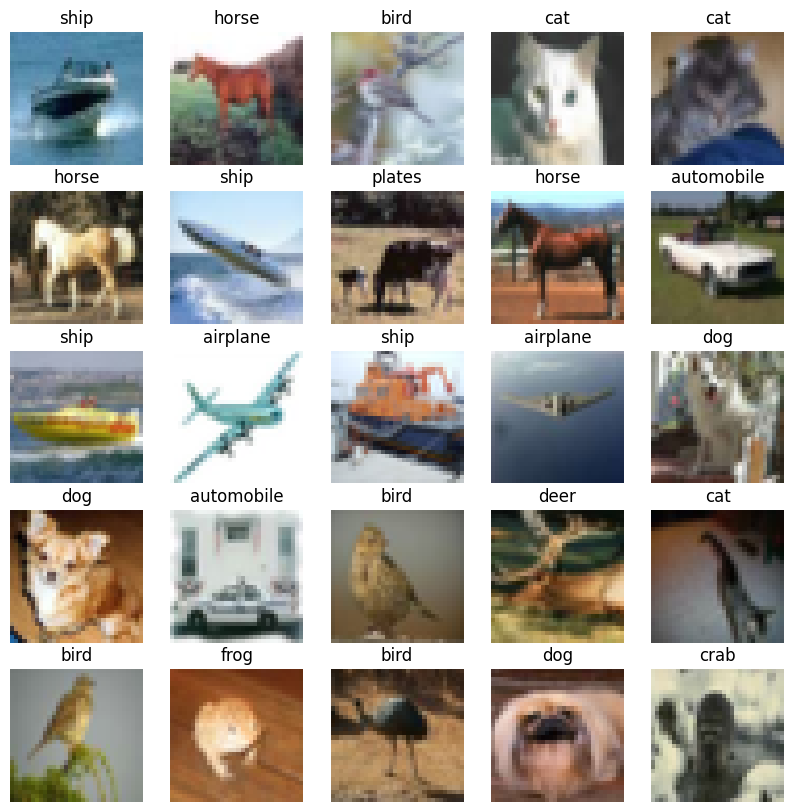

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt

batch = next(iter(train_loader_op))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(combined_label_dict[labels[i].item()])
    plt.axis('off')
plt.show()

In [ ]:
#초기 신경망 생성 및 장치에 저장
model_res_c = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_op = train_and_evaluate(model_res_c, device, train_loader_op, test_loader, epochs=5)

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

###오염된 양 증가

In [ ]:
train_set_20 = ood_label(train_set, add_set, attack_ratio=0.2)
train_loader_20 = DataLoader(dataset = train_set_20, batch_size=64, shuffle=True)

train_set_40 = ood_label(train_set, add_set, attack_ratio=0.4)
train_loader_40 = DataLoader(dataset = train_set_40, batch_size=64, shuffle=True)

train_set_60 = ood_label(train_set, add_set, attack_ratio=0.6)
train_loader_60 = DataLoader(dataset = train_set_60, batch_size=64, shuffle=True)

In [ ]:
#초기 신경망 생성 및 장치에 저장
model_res_20 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_40 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_res_60 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [ ]:
acc_res_20 = train_and_evaluate(model_res_20, device, train_loader_20, test_loader, epochs=5)

In [ ]:
acc_res_40 = train_and_evaluate(model_res_40, device, train_loader_40, test_loader, epochs=5)

[Epoch 1] loss: 2.186
Accuracy: 38.50%
[Epoch 2] loss: 2.083
Accuracy: 41.39%
[Epoch 3] loss: 2.014
Accuracy: 48.56%
[Epoch 4] loss: 1.970
Accuracy: 56.12%
[Epoch 5] loss: 1.922
Accuracy: 54.89%


In [ ]:
acc_res_60 = train_and_evaluate(model_res_60, device, train_loader_60, test_loader, epochs=5)

[Epoch 1] loss: 2.274
Accuracy: 29.44%
[Epoch 2] loss: 2.220
Accuracy: 31.26%
[Epoch 3] loss: 2.198
Accuracy: 36.42%
[Epoch 4] loss: 2.182
Accuracy: 39.03%
[Epoch 5] loss: 2.169
Accuracy: 41.04%


###최종 비교 그래프

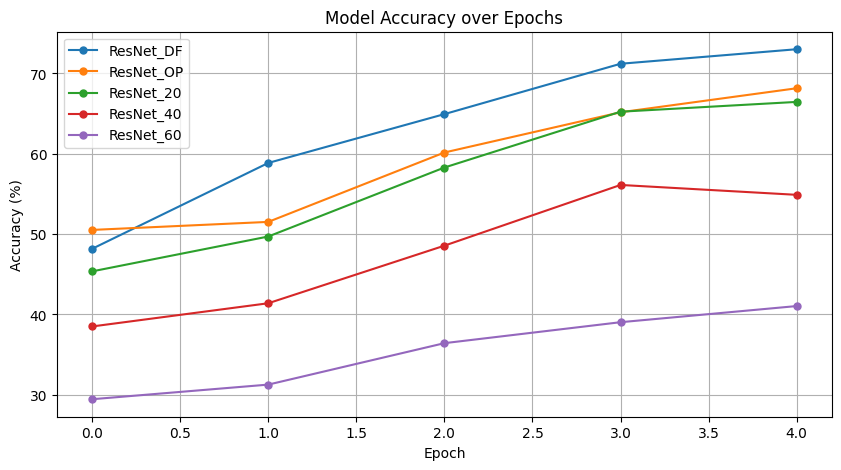

In [ ]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_DF')
plt.plot(acc_res_op, marker='o', linestyle='-', markersize=5, label='ResNet_OP')
plt.plot(acc_res_20, marker='o', linestyle='-', markersize=5, label='ResNet_20')
plt.plot(acc_res_40, marker='o', linestyle='-', markersize=5, label='ResNet_40')
plt.plot(acc_res_60, marker='o', linestyle='-', markersize=5, label='ResNet_60')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

결론: ResNet50에 대한 공격 효용성이 매우 강함

In [ ]:
# Random Label 알고리즘 검증용
train_set_all = load_and_combine_datasets(train_set, attack_ratio=1)
train_loader_all = DataLoader(train_set_all, batch_size=64, shuffle=True)

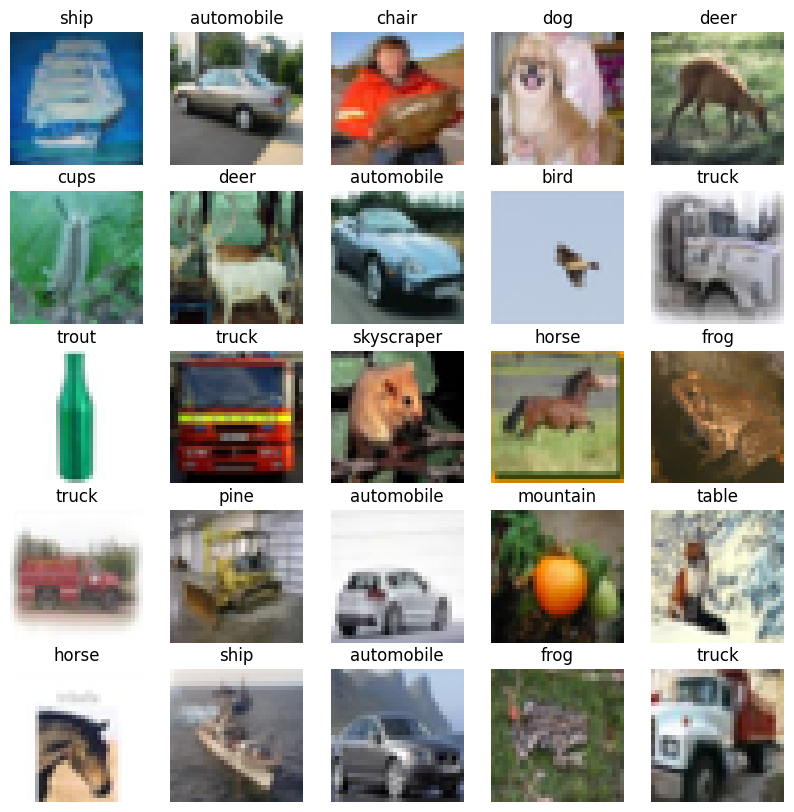

In [ ]:
# Visualization of train dataset samples
import matplotlib.pyplot as plt


batch = next(iter(train_loader_all))
images, labels = batch

grid_img = torchvision.utils.make_grid(images[:25], nrow=5, padding=5)

# Display titles below each image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  # Permute dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.title(combined_label_dict[labels[i].item()])
    plt.axis('off')
plt.show()